In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn import metrics
from math import sqrt
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import cross_validate
df = pd.read_csv('result.csv')

rows_drop = []
for index, row in df.iterrows():
    if row[2:].isnull().sum()/len(row[2:]) > 0.5:
        rows_drop.append(index)
df = df.drop(rows_drop, axis=0)

region = df.region_name.unique()    
def split_region(i):
    val_state = (region[i],region[i+1])
    train = df.loc[~np.in1d(df['region_name'], val_state)]
    val = df.loc[np.in1d(df['region_name'], val_state)]
    return (train, val)

### Normalization

In [2]:
features = list(df.columns.values)
features.remove('region_name')
features.remove('date')
features.remove('hospitalized_new')

region = df.region_name.unique()
factor = []

#ignore nan warning we will deal with nan later 
np.warnings.filterwarnings('ignore')
for re in region:
    median = []
    df_new = df.loc[np.in1d(df['region_name'], re)]
    for feature in features:
        array = df_new[feature].values.tolist()
        median.append(np.nanmedian(array))
    factor.append(np.nanmedian(median))   

df = df.fillna(0)
normal = factor[0]/factor
print(normal)

i = 0
for re in region:
    for feature in features:
        df.loc[np.in1d(df['region_name'], re),feature] = df.loc[np.in1d(df['region_name'], re),feature].map(lambda x: x*normal[i])
    i = i + 1
print(df.head())

[1.         0.79510518 1.15278592 0.9778607  0.86130587 2.83621934]
  region_name        date  symptom:Adrenal crisis  symptom:Ageusia  \
0      Alaska  2020-03-09                   10.60             0.00   
1      Alaska  2020-03-16                   11.69             0.00   
2      Alaska  2020-03-23                   11.15            16.57   
3      Alaska  2020-03-30                    8.96             8.96   
4      Alaska  2020-04-06                   10.08             7.35   

   symptom:Allergic conjunctivitis  symptom:Amblyopia  symptom:Amenorrhea  \
0                            11.61                0.0               12.79   
1                             6.39                0.0                0.00   
2                             0.00                0.0                9.53   
3                             7.11                0.0                8.53   
4                             0.00                0.0               10.80   

   symptom:Angular cheilitis  symptom:Anosmia  s

### Model split by region

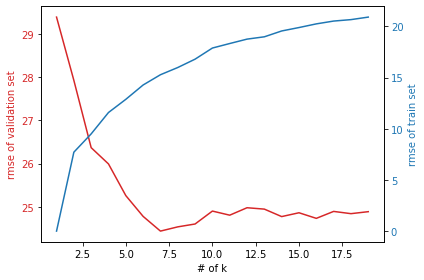

Minimal RMSE 24.44 found when k = 6


In [3]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
group = df.region_name.astype("category").cat.codes
group_kfold = GroupKFold(6)

rmse = np.empty(19)
rmse_train = np.empty(19)
for k in range(1,20):
    res = cross_validate(KNN(k), X, y, scoring='neg_root_mean_squared_error', groups=group, cv=group_kfold,return_train_score=True)
    rmse[k-1] = res['test_score'].mean() *(-1) 
    rmse_train[k-1] = res['train_score'].mean() *(-1)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse of validation set', color=color)
ax1.plot(range(1,20),rmse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('rmse of train set', color=color)
ax2.plot(range(1,20),rmse_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
print("Minimal RMSE %.2f" % min(rmse), end=" found when k = ")
for i, value in enumerate(rmse):
    if value == min(rmse):
        print (i)

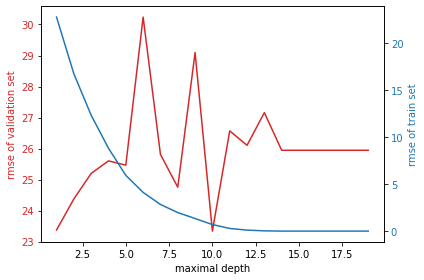

Minimal RMSE 23.34 found when maximal depth = 9


In [4]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
group = df.region_name.astype("category").cat.codes
group_kfold = GroupKFold(6)

rmse = np.empty(19)
rmse_train = np.empty(19)
for k in range(1,20):
    res = cross_validate(DTR(max_depth=k,random_state=5), X, y, scoring='neg_root_mean_squared_error', groups=group, cv=group_kfold, return_train_score=True)
    rmse[k-1] = res['test_score'].mean() *(-1) 
    rmse_train[k-1] = res['train_score'].mean() *(-1)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('maximal depth')
ax1.set_ylabel('rmse of validation set', color=color)
ax1.plot(range(1,20),rmse, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('rmse of train set', color=color) 
ax2.plot(range(1,20),rmse_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
print("Minimal RMSE %.2f" % min(rmse), end=" found when maximal depth = ")
for i, value in enumerate(rmse):
    if value == min(rmse):
        print (i)


### Models Split by Time

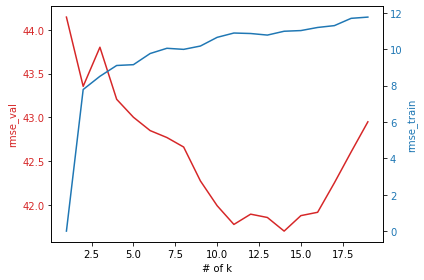

Minimal RMSE 23.34 found when k = 13


In [5]:
score_list = []
score_list_train = []
train = df.loc[df['date'] < '2020-08-10']
val = df.loc[df['date'] >= '2020-08-10']
for k in range(1,20):
    knn = KNN(k)
    knn.fit(train.iloc[:,2:-1],train.iloc[:,-1])
    y_pred = knn.predict(val.iloc[:,2:-1])
    y_train = knn.predict(train.iloc[:,2:-1])
    score_list.append(sqrt(metrics.mean_squared_error(val.iloc[:,-1],y_pred)))
    score_list_train.append(sqrt(metrics.mean_squared_error(train.iloc[:,-1],y_train)))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse_val', color=color)
ax1.plot(range(1,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx() 

color = 'tab:blue'
ax2.set_ylabel('rmse_train', color=color) 
ax2.plot(range(1,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
print("Minimal RMSE %.2f" % min(score_list), end=" found when k = ")
for i, value in enumerate(score_list):
    if value == min(score_list):
        print (i)


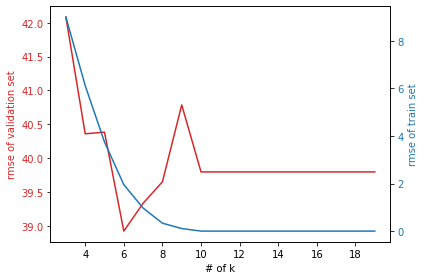

Minimal RMSE 23.34 found when maximal depth = 3


In [6]:
score_list = []
score_list_train = []
train = df.loc[df['date'] < '2020-08-10']
val = df.loc[df['date'] >= '2020-08-10']
for k in range(3,20):
    dtr = DTR(max_depth=k,random_state=5)
    dtr.fit(train.iloc[:,2:-1],train.iloc[:,-1])
    y_pred = dtr.predict(val.iloc[:,2:-1])
    y_train = dtr.predict(train.iloc[:,2:-1])
    score_list.append(sqrt(metrics.mean_squared_error(val.iloc[:,-1],y_pred)))
    score_list_train.append(sqrt(metrics.mean_squared_error(train.iloc[:,-1],y_train)))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('# of k')
ax1.set_ylabel('rmse of validation set', color=color)
ax1.plot(range(3,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('rmse of train set', color=color) 
ax2.plot(range(3,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()
print("Minimal RMSE %.2f" % min(score_list), end=" found when maximal depth = ")
for i, value in enumerate(score_list):
    if value == min(score_list):
        print (i)

### Model: Random Forest

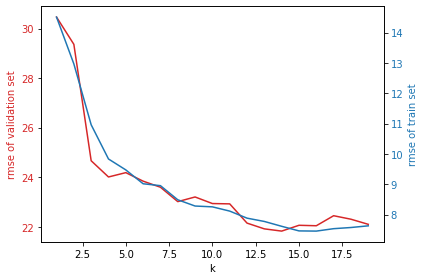

Minimal RMSE 23.34 found when k = 13


In [7]:
X = df.iloc[:,2:-1]
y = df.iloc[:,-1]
group = df.region_name.astype("category").cat.codes
group_kfold = GroupKFold(6)
score_list = []
score_list_train = []
for k in range(1,20):
    res = cross_validate(RFR(k,random_state=5), X, y, scoring='neg_root_mean_squared_error', groups=group, cv=group_kfold, return_train_score=True)
    score_list.append(res['test_score'].mean() *(-1))
    score_list_train.append(res['train_score'].mean() *(-1))

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('rmse of validation set', color=color)
ax1.plot(range(1,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('rmse of train set', color=color)
ax2.plot(range(1,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout() 
plt.show()
print("Minimal RMSE %.2f" % min(score_list), end=" found when k = ")
for i, value in enumerate(score_list):
    if value == min(score_list):
        print (i)

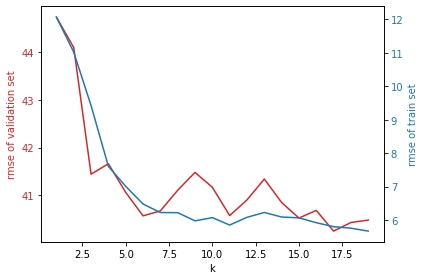

Minimal RMSE 23.34 found when k = 16


In [8]:
score_list = []
score_list_train = []
train = df.loc[df['date'] < '2020-08-10']
val = df.loc[df['date'] >= '2020-08-10']
for k in range(1,20):
    rfr = RFR(k,random_state=5)
    rfr.fit(train.iloc[:,2:-1],train.iloc[:,-1])
    y_pred = rfr.predict(val.iloc[:,2:-1])
    y_train = rfr.predict(train.iloc[:,2:-1])
    score_list.append(sqrt(metrics.mean_squared_error(val.iloc[:,-1],y_pred)))
    score_list_train.append(sqrt(metrics.mean_squared_error(train.iloc[:,-1],y_train)))
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('k')
ax1.set_ylabel('rmse of validation set', color=color)
ax1.plot(range(1,20),score_list, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('rmse of train set', color=color)
ax2.plot(range(1,20),score_list_train, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()
print("Minimal RMSE %.2f" % min(score_list), end=" found when k = ")
for i, value in enumerate(score_list):
    if value == min(score_list):
        print (i)
        